# Example of running a basic VASP calculation using aiida-vasp

## Load the necessary AiiDA environment

The cell below will use an temporary in-memory AiiDA profile. All results will be destroyed once the session close.

In actual production environment you need:

```
%load_ext aiida
%aiida
```

instead.

In [1]:
%load_ext aiida

from aiida import load_profile, engine, orm, plugins
from aiida.storage.sqlite_temp import SqliteTempBackend

profile = load_profile(
    SqliteTempBackend.create_profile(
        'myprofile',
        sandbox_path='_sandbox',
        options={
            'warnings.development_version': False,
            'runner.poll.interval': 1
        },
        debug=False
    ),
    allow_switch=True
)
profile

Profile<uuid='4b958b6523fe490eb2f716bc950cc1a1' name='myprofile'>

## Setting up a simple silicon calculation

In this example we setup a single point calculation of silicon using aiida and aiida-vasp.
The provenance graph of the expected calculation input and outputs are shown below.

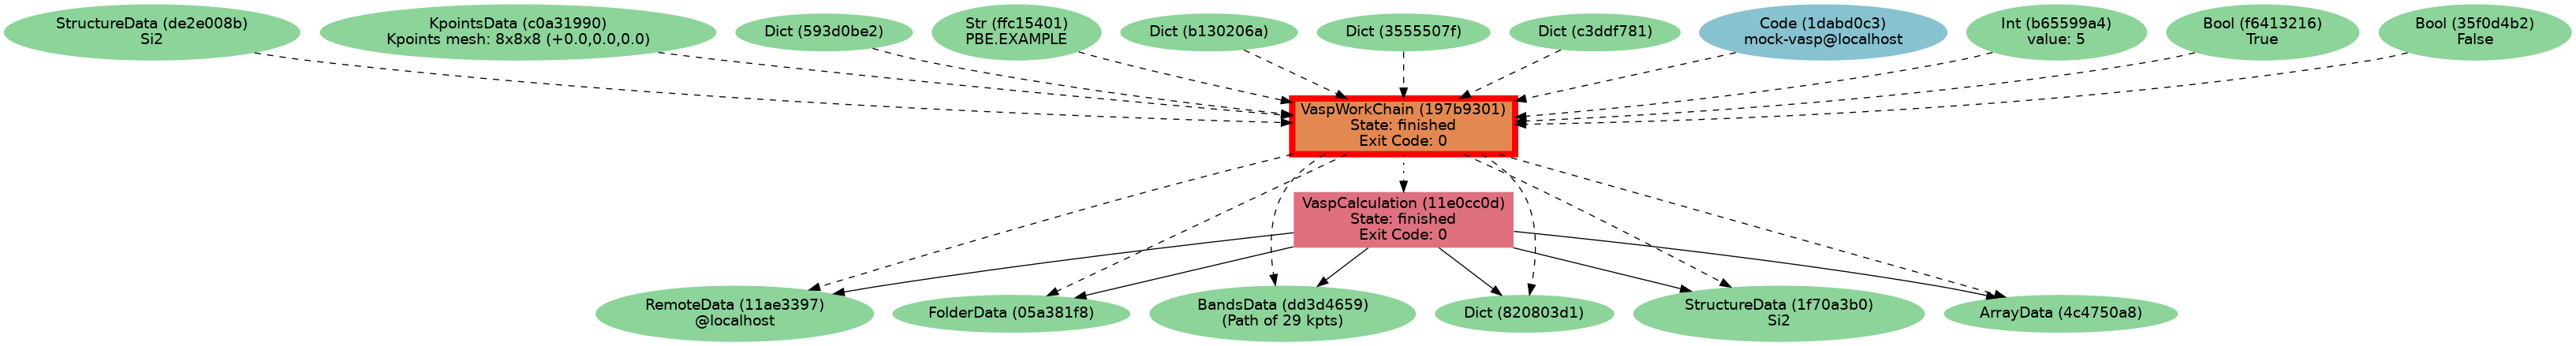

In [2]:
# A example of the provenance graph of a CastepCalculation
from IPython.display import Image
Image("./provenance1.png")

In [3]:
# pylint: disable=too-many-arguments
import numpy as np
from aiida.common.extendeddicts import AttributeDict
from aiida.orm import Code, Bool, Str
from aiida.plugins import DataFactory, WorkflowFactory, CalculationFactory
from aiida.engine import submit
from pathlib import Path

First, setup a Silicon structure. 

In addition to the methods below, one may also convert `ase.Atoms` and `pymatgen.core.Structure` with `orm.StructureData(ase=obj)` or `orm.StructureData(pymatgen=obj)`.

In [4]:
dict_data = DataFactory('core.dict')
kpoints_data = DataFactory('core.array.kpoints')

def get_structure():
    """
    Set up Si primitive cell

    Si
       5.431
         0.0000000000000000    0.5000000000000000    0.5000000000000000
         0.5000000000000000    0.0000000000000000    0.5000000000000000
         0.5000000000000000    0.5000000000000000    0.0000000000000000
    Si
       2
    Direct
      0.8750000000000000  0.8750000000000000  0.8750000000000000
      0.1250000000000000  0.1250000000000000  0.1250000000000000

    """

    structure_data = DataFactory('core.structure')
    alat = 5.431
    lattice = np.array([[.5, 0, .5], [.5, .5, 0], [0, .5, .5]]) * alat
    structure = structure_data(cell=lattice)
    for pos_direct in ([0.875, 0.875, 0.875], [0.125, 0.125, 0.125]):
        pos_cartesian = np.dot(pos_direct, lattice)
        structure.append_atom(position=pos_cartesian, symbols='Si')
    return structure

The `VaspWorkChain` class can be loaded using the `CalculationFactory` function.

In [5]:
VaspWorkChain = WorkflowFactory('vasp.vasp')

### The easiest way of setting up an calculation is to use a `ProcessBuilder`.

Such builder object allows input nodes to be passed to the forthcoming the calculation interactively.

In [6]:
builder = VaspWorkChain.get_builder()
builder

Process class: VaspWorkChain
Inputs:
dynamics: {}
metadata: {}


### Set the structure

In [7]:
builder.structure = get_structure()
print(builder.structure.cell)
print(builder.structure.sites)

[[2.7155, 0.0, 2.7155], [2.7155, 2.7155, 0.0], [0.0, 2.7155, 2.7155]]
[<Site: kind name 'Si' @ 4.752125,4.752125,4.752125>, <Site: kind name 'Si' @ 0.678875,0.678875,0.678875>]


### Set up the kpoints

here we use an explicit mesh of `8x8x8`

In [8]:
kpoints = kpoints_data()
kpoints.set_cell_from_structure(builder.structure)
kpoints.set_kpoints_mesh([8, 8, 8])
builder.kpoints = kpoints
builder

Process class: VaspWorkChain
Inputs:
dynamics: {}
kpoints: 'Kpoints mesh: 8x8x8 (+0.0,0.0,0.0)'
metadata: {}
structure: Si


AiiDA also provides an interface to set the kpoints using density (in unit $\unicode{x212B}^ {-1}$)

In [9]:
builder.kpoints.set_kpoints_mesh_from_density(0.27)
builder.kpoints.get_kpoints_mesh()

([8, 8, 8], [0.0, 0.0, 0.0])

### Setting up the INCAR

The incar is passed as parameters to the workchain, the actual tags should be placed under the `incar` field of the `parameters`

In [10]:
incar = {'incar': {'prec': 'normal', 'encut': 200, 'ediff': 1E-4, 'ialgo': 38, 'ismear': -5, 'sigma': 0.1}}
builder.parameters = dict_data(dict=incar)

### pseudopotential family and mappings

A family is a collection of pseudopotentials, in analogy to the PAW dataset released by VASP.   
The concept of family here is different from that of `aiida-pseudo`, such there can be more than one pseudopotential for a single element.  
Hence, in addition to the family, a mapping between the species and the POTCAR to be used is also needed.

In [11]:
builder.potential_family = orm.Str('PBE.EXAMPLE')
builder.potential_mapping = orm.Dict(dict={'Si': 'Si'})

### Other inputs

- `setting` defines a few internal settings controlling how the plugin operates
- `options` defines the `metadata.options` to be passed to lower level `VaspCalculation`. A `VaspCalculation` represents an actual VASP calculation, while a `VaspWorhChain` (that we are setting up now) is capable of launching multiple calculations in case of any error/issues.

In [12]:
# Options often contain information about how to launch the actual VASP calculation 
builder.options = orm.Dict(dict={'resources': {'num_machines':1, 'tot_num_mpiprocs': 1}, 'max_wallclock_seconds': 3600, 'withmpi': False})
# request the parser to parse the structures 
builder.settings = orm.Dict(dict={'parser_settings': {'add_structure': True, 'add_bands': True, 'add_forces': True}})

### The `Code` input

The `code` input controls where the vasp calculation will be run (e.g. which computer) and which executable (e.g path on that computer) to use.

Since the database is empty, we create our own code from scratch. Otherwise, one typically reuse existing codes previously defined, typically using `verdi code create`.

In this example, we have to create a `Computer` that is this computer (localhost).

In [13]:
# Uncomment the below line to create a localhost Computer if you have not done so
comp = orm.Computer('localhost', 'localhost', transport_type='core.local', scheduler_type='core.direct')
comp.store()


# Some configuration may be needed for first-time user
comp.set_workdir('/tmp/aiida_run/')
comp.configure()

Now we can create a code. This is a mock code just match the input files with existing pre-calculated output file.
When you run real VASP, the path to the vasp executables should be used instead. 

Since VASP uses different executables for gamma only (`vasp_gam`), standard (`vasp_std`) and non-colinear spin calculation (`vasp_ncl`), one `Code` for each executable.

In [14]:
import os

In [15]:
# Define a mock code on the localhost computer

# Find the path of mock-vasp (installed with the plugin)
code_path = !which mock-vasp

# For running with real VASP 
#code_path = !which vasp_std

vasp_mock = orm.Code((comp, code_path[0]), input_plugin_name='vasp.vasp')
# Ensure that we are using the correct registry
vasp_mock.set_prepend_text(f"export VASP_MOCK_CODE_BASE={os.getcwd()}/mock_registry")

builder.code = vasp_mock

## Pseudopotentials

We have to upload the actual pseduopotentials to the database. Normally, this would be the folder of all POTCAR files shipped with VASP. Here, we just upload the `Si` POTCAR, as obtained from VASP wiki.

In [16]:
from aiida_vasp.data.potcar import PotcarData, PotcarFileData

PotcarData.upload_potcar_family(str(Path('potcars').absolute()), "PBE.EXAMPLE", "PBE.EXAMPLE")

(1, 1, 1)

## Submit the calculation

We can now submit the calculation. 

In this example, we use the `run_get_node` function, but in practice, one typically uses the `submit` function to submit the calculation/workflow and let the daemon to pick it up for running in the background.

In [17]:
from aiida.engine import run_get_node, submit

In [18]:
results, node = run_get_node(builder)

06/03/2022 06:16:39 PM <15120> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [14|VaspWorkChain|run_process]: launching VaspCalculation<16> iteration #1
06/03/2022 06:16:43 PM <15120> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [14|VaspWorkChain|results]: work chain completed after 1 iterations
06/03/2022 06:16:43 PM <15120> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [14|VaspWorkChain|results]: required output 'custom_outputs' was not an output of VaspCalculation<16> (or an incorrect class/output is being exposed).
06/03/2022 06:16:43 PM <15120> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [14|VaspWorkChain|on_terminated]: cleaned remote folders of calculations: 16


### Check if the workflows finishes OK

All `Process` in AiiDA uses the concept of *exit status* (or *exit code*). A process with `0` *exit status* means it finished without any problem.
This is in analogy to the processes on Linux. 

Should be empty if the calculation finishes without any problem

In [19]:
node.exit_message

Should be `0` if everything is fine

In [20]:
node.exit_status

0

### DEV ONLY - upload mock the calculation to the mock registry

The code blow is for uploading calculation ran with real VASP to the mock registry

## Accessing the results

AiiDA parsers the output of the calculations and store them in the database as output nodes. 

The easiest way to access them is to use the `outputs` attribute of the `WorkChainNode` object.

`misc` stores various important outputs.

In [21]:
node.outputs.misc.get_dict()

{'total_energies': {'energy_extrapolated': -10.79449573,
  'energy_extrapolated_electronic': -10.79449573},
 'maximum_stress': 18.17885983,
 'maximum_force': 0.0,
 'notifications': [],
 'run_status': {'nelm': 60,
  'nsw': 0,
  'last_iteration_index': [1, 9],
  'finished': True,
  'ionic_converged': None,
  'electronic_converged': True,
  'consistent_nelm_breach': False,
  'contains_nelm_breach': False,
  'nbands': 8},
 'run_stats': {'mem_usage_base': 30000.0,
  'mem_usage_nonl-proj': 515.0,
  'mem_usage_fftplans': 800.0,
  'mem_usage_grid': 1216.0,
  'mem_usage_one-center': 6.0,
  'mem_usage_wavefun': 1072.0,
  'total_cpu_time_used': 0.735,
  'user_time': 0.663,
  'system_time': 0.072,
  'elapsed_time': 0.806,
  'maximum_memory_used': 63948.0,
  'average_memory_used': None},
 'version': '6.2.0'}

Since we requested the structure to be parsed, the output structure is also returned.
Because here we just run a simple singlepoint calculation, it is identical to the input structure.

In [22]:
node.outputs.structure.sites

[<Site: kind name 'Si' @ 4.752125,4.752125,4.752125>,
 <Site: kind name 'Si' @ 0.678875,0.678875,0.678875>]

In [23]:
node.inputs.structure.sites

[<Site: kind name 'Si' @ 4.752125,4.752125,4.752125>,
 <Site: kind name 'Si' @ 0.678875,0.678875,0.678875>]

In [24]:
node.outputs.forces.get_array('final')

array([[ 0., -0., -0.],
       [-0.,  0.,  0.]])

Access the eigenvalues with an array of shape (nspin, nkpoints, nbands)

In [25]:
node.outputs.bands.get_array('bands').shape

(1, 29, 8)

The kpoints are also available

In [26]:
node.outputs.bands.get_array('kpoints').shape

(29, 3)

## Accessing raw calculation outputs

AiiDA does not limit you to use only the tools integrated with AiiDA itself. Other analysis tools can also be used to process the calculation stored in AiiDA. 
By default, the raw input and output files are all stored.

The retrieved calculation outputs are stored inside `node.outputs.retrieved`.

In [27]:
node.outputs.retrieved.base.repository.list_object_names()

['CONTCAR',
 'DOSCAR',
 'EIGENVAL',
 'OUTCAR',
 '_scheduler-stderr.txt',
 '_scheduler-stdout.txt',
 'vasp_output',
 'vasprun.xml']

here is an example of accessing the raw `OUTCAR` file

In [28]:
with node.outputs.retrieved.base.repository.open("OUTCAR") as fh:
    lines = fh.readlines()
    print(''.join(lines[-50:]))



--------------------------------------------------------------------------------------------------------


    POTLOK:  cpu time    0.0082: real time    0.0082


--------------------------------------------------------------------------------------------------------


 stress matrix after NEB project (eV)
      0.45440     -0.00000      0.00000
      0.00000      0.45440     -0.00000
     -0.00000     -0.00000      0.45440
  FORCES: max atom, RMS     0.000000    0.000000
  FORCE total and by dimension    0.000000    0.000000
  Stress total and by dimension    0.787039    0.454397
 writing wavefunctions
     LOOP+:  cpu time    0.4613: real time    0.4617
    4ORBIT:  cpu time    0.0000: real time    0.0000
 BZINTS: Fermi energy:    6.468711;    8.000000 electrons
         Band energy: 0.615623E+01;  BLOECHL correction:    0.000000

 total amount of memory used by VASP MPI-rank0    33609. kBytes

   base      :      30000. kBytes
   nonl-proj :        515. kBytes
   fftplans  :       

Sometimes, existing analysis code works only with *folders of calculations*.

Here is an example of exporting the calculation performed for post-processing with third-party packages.

In [29]:
node.outputs.retrieved.base.repository.copy_tree(Path("si-calc-export").absolute())
node.base.repository.copy_tree(Path("si-calc-export").absolute())

In [30]:
!ls si-calc-export

CONTCAR  EIGENVAL  _scheduler-stderr.txt  vasp_output
DOSCAR	 OUTCAR    _scheduler-stdout.txt  vasprun.xml


## Provenance graph

One of the main benefits of using AiiDA is that the provenance all data is stored in a DAG (directed acyclic graph).

The graph can be visualized for inspection.

In [31]:
from aiida.tools.visualization.graph import Graph

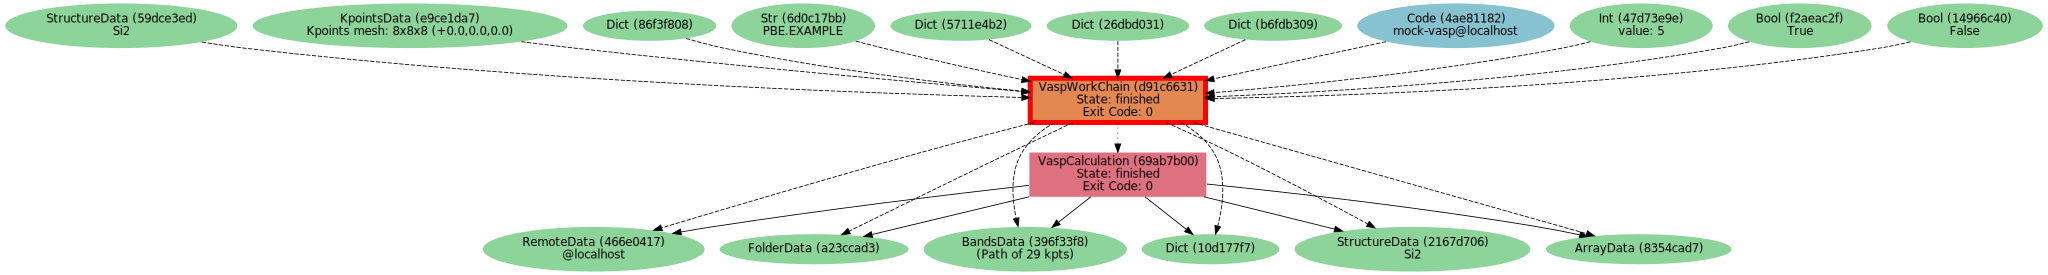

In [32]:
g = Graph(node_id_type='uuid')
g.recurse_descendants(node, )
g.recurse_ancestors(node)
g.graphviz

Note that the UUID of each node are different from that shown in the top of this notebook - all nodes can be uniquely referenced with their UUID, which will not change upon data export.